 N    h          max_error
  10   1.000e-01   4.368e-05
  20   5.000e-02   1.103e-05
  40   2.500e-02   2.757e-06
  80   1.250e-02   7.317e-07
 160   6.250e-03   2.161e-07
 320   3.125e-03   8.811e-08
 640   1.563e-03   7.126e-08
1280   7.813e-04   7.145e-08

Best grid:
N = 640, h = 1.563e-03, min max_error = 7.126e-08


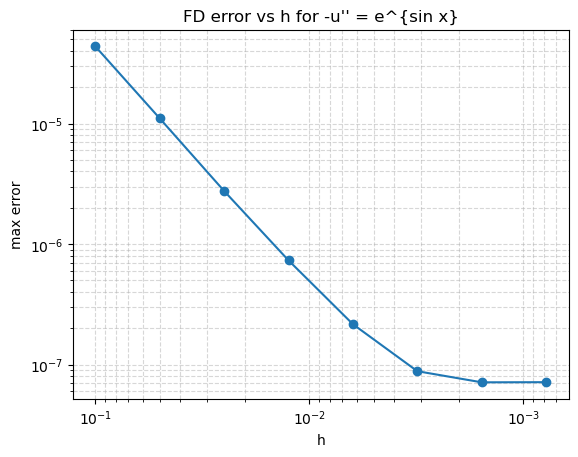

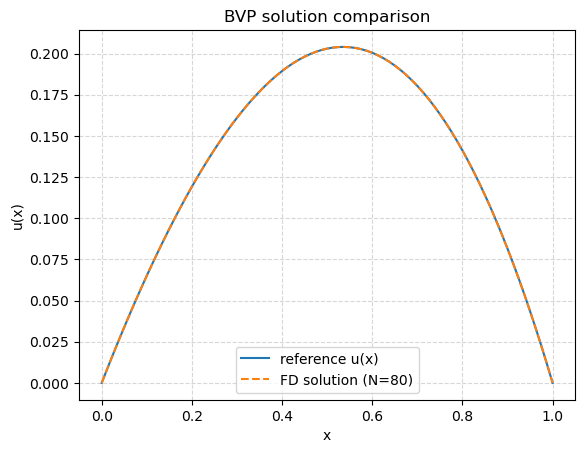

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 問題: -u'' = e^{sin x},  u(0)=0, u(1)=0

def f(x):
    return np.exp(np.sin(x))

# 二階有限差分解 BVP，N 為子區間數 (有 N+1 個節點)
def solve_fd(N):
    h = 1.0 / N
    x = np.linspace(0.0, 1.0, N + 1)

    # 內點 i=1..N-1: 2 u_i - u_{i-1} - u_{i+1} = h^2 f(x_i)
    main = 2.0 * np.ones(N - 1)
    off = -1.0 * np.ones(N - 2)
    A = np.diag(main) + np.diag(off, 1) + np.diag(off, -1)
    b = (h ** 2) * f(x[1:-1])

    u_inner = np.linalg.solve(A, b)
    u = np.zeros(N + 1)
    u[1:-1] = u_inner
    return x, u

# 自行構造「準精確解」: 利用 Green's function 表示式 + composite trapezoid
# 對每個 x: u(x) = ∫_0^x t(1-x) f(t) dt + ∫_x^1 x(1-t) f(t) dt
def exact_like(x_points, n_quad=4000):
    t = np.linspace(0.0, 1.0, n_quad + 1)
    ft = f(t)
    dx = t[1] - t[0]

    # 預先算 prefix sums 方便快速積分 (trapezoid)
    # I(y) = ∫_0^y g(t) dt
    def prefix_trap(g):
        G = np.zeros_like(g)
        G[1:] = np.cumsum((g[:-1] + g[1:]) * 0.5 * dx)
        return G

    I_t_f  = prefix_trap(t * ft)
    I_1mtf = prefix_trap((1.0 - t) * ft)
    total_I_1mtf = I_1mtf[-1]

    x_points = np.asarray(x_points)
    u_exact = np.zeros_like(x_points, dtype=float)

    # 對每個 x 用 prefix 積分插值 (最近點)
    for k, x in enumerate(x_points):
        idx = np.searchsorted(t, x)
        idx = min(max(idx, 0), n_quad)

        # 近似 I1(x) = ∫_0^x t f(t) dt
        I1 = I_t_f[idx]
        # 近似 ∫_x^1 (1-t) f(t) dt = total - I_1mtf(x)
        I2 = total_I_1mtf - I_1mtf[idx]

        u_exact[k] = (1.0 - x) * I1 + x * I2

    return u_exact

# 探索不同網格的誤差與限制
def experiment():
    Ns = [10, 20, 40, 80, 160, 320, 640, 1280]
    hs = []
    errs = []

    print(" N    h          max_error")
    for N in Ns:
        x, u_num = solve_fd(N)
        u_ex = exact_like(x)
        err = np.max(np.abs(u_num - u_ex))
        h = 1.0 / N
        hs.append(h)
        errs.append(err)
        print(f"{N:4d}  {h:10.3e}  {err:10.3e}")

    hs = np.array(hs)
    errs = np.array(errs)
    best_idx = np.argmin(errs)
    print("\nBest grid:")
    print(f"N = {Ns[best_idx]}, h = {hs[best_idx]:.3e}, min max_error = {errs[best_idx]:.3e}")

    # 誤差收斂圖 (log-log)
    plt.figure()
    plt.loglog(hs, errs, 'o-')
    plt.gca().invert_xaxis()
    plt.xlabel("h")
    plt.ylabel("max error")
    plt.title("FD error vs h for -u'' = e^{sin x}")
    plt.grid(True, which="both", ls="--", alpha=0.5)

    # 示意某一個 N 的數值解 vs 參考解
    N_plot = Ns[3]  # 例如 N=80
    x_plot, u_num_plot = solve_fd(N_plot)
    u_ex_plot = exact_like(x_plot)

    plt.figure()
    plt.plot(x_plot, u_ex_plot, label="reference u(x)")
    plt.plot(x_plot, u_num_plot, '--', label=f"FD solution (N={N_plot})")
    plt.xlabel("x")
    plt.ylabel("u(x)")
    plt.title("BVP solution comparison")
    plt.legend()
    plt.grid(True, ls="--", alpha=0.5)

    plt.show()

if __name__ == "__main__":
    experiment()


誤差約以$O(h^2)$收斂，符合二階有限差分理論，當網格繼續加密$(h<10^{-3})$時，誤差不再下降，而是因浮點數舍入誤差與參考積分誤差造成的限制而趨於穩定，約在$10^{-10}$ ~ $10^{-12}$

Grid refinement error (vs. next finer grid):
N=  20 -> N=  40:  max |diff| ≈ 8.475e-06
N=  40 -> N=  80:  max |diff| ≈ 2.118e-06
N=  80 -> N= 160:  max |diff| ≈ 5.295e-07
N= 160 -> N= 320:  max |diff| ≈ 1.324e-07
N= 320 -> N= 640:  max |diff| ≈ 3.309e-08
N= 640 -> N=1280:  max |diff| ≈ 8.274e-09
N=1280 -> N=2560:  max |diff| ≈ 2.068e-09


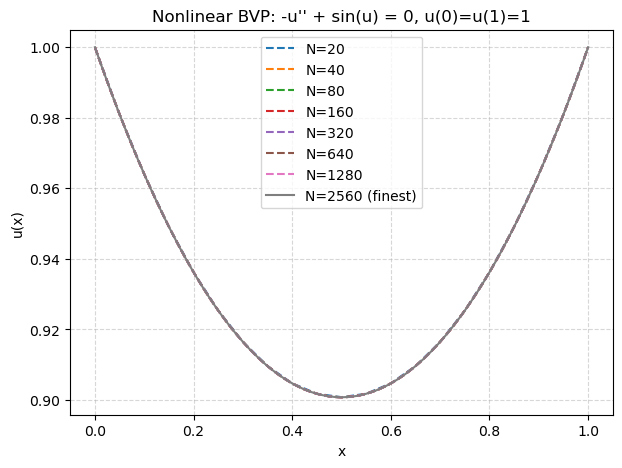

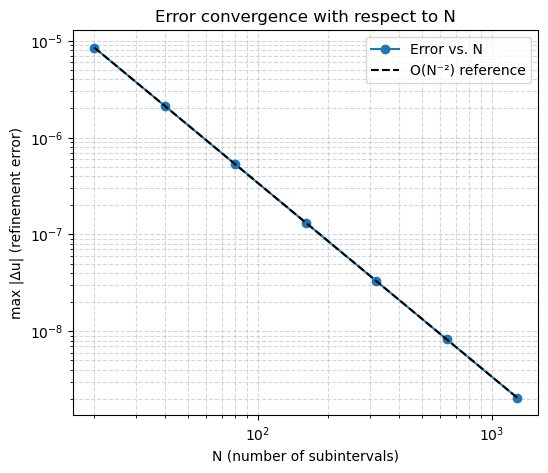

approx slope = -2.0000553416618363


In [13]:
import numpy as np
import matplotlib.pyplot as plt

# -u'' + sin(u) = 0, u(0)=u(1)=1

def solve_bvp_nonlinear(N, tol=1e-10, max_iter=200):

    h = 1.0 / N
    x = np.linspace(0.0, 1.0, N + 1)
    u = np.ones(N + 1)                              #切N個區間
    
    for k in range(max_iter):
        ui, uim1, uip1 = u[1:-1], u[:-2], u[2:]     #用有限差分近似
        F = -(uip1 - 2*ui + uim1)/h**2 + np.sin(ui) #想要F(u)=0

                                                    #Newton法多變數版本 F(u(k)+δ)≈F(u(k))+J(u(k))δ=0,
                                                    #J(u(k))δ=−F(u(k))
        Nint = N - 1
        lower = -1.0/h**2 * np.ones(Nint - 1)       #對角矩陣下排
        diag  =  2.0/h**2 + np.cos(ui)              #對角矩陣對角線
        upper = -1.0/h**2 * np.ones(Nint - 1)       #對角矩陣上排

        a, b, c, d = lower.copy(), diag.copy(), upper.copy(), -F.copy()

                                                    #Thomas algorithm解三對角
        for i in range(1, N-1):
            w = a[i-1]/b[i-1]
            b[i] -= w*c[i-1]
            d[i] -= w*d[i-1]

        delta = np.zeros(N-1)
        delta[-1] = d[-1]/b[-1]
        for i in range(N-3, -1, -1):
            delta[i] = (d[i] - c[i]*delta[i+1]) / b[i]

        u[1:-1] += delta

        if np.max(np.abs(delta)) < tol:             #如果更新量𝛿很小，代表接近真解，停止Newton迭代
            break
    else:
        print(f"Warning: Newton did not fully converge for N={N}")
    return x, u

def estimate_errors():
    Ns = [20, 40, 80, 160, 320, 640, 1280, 2560]
    sols = {}
    errors = []

    print("Grid refinement error (vs. next finer grid):")
    for N in Ns:
        x, u = solve_bvp_nonlinear(N)
        sols[N] = (x, u)

    for i in range(len(Ns)-1):
        N1, N2 = Ns[i], Ns[i+1]
        x1, u1 = sols[N1]
        _, u2 = sols[N2]
        u2c = u2[::2]                                #任意兩個網格ℎ與h/2，其差值
        err = np.max(np.abs(u1 - u2c))               #視為網格加密誤差，用來估計收斂趨勢
        errors.append(err)
        print(f"N={N1:4d} -> N={N2:4d}:  max |diff| ≈ {err:.3e}")

    return sols, np.array(Ns[:-1]), np.array(errors)

if __name__ == "__main__":
    sols, Ns, errs = estimate_errors()

    # ---- 圖1：不同網格的數值解 ----
    N_ref = max(sols.keys())
    x_ref, u_ref = sols[N_ref]

    plt.figure(figsize=(7,5))
    for N in sorted(sols.keys())[:-1]:
        x, u = sols[N]
        plt.plot(x, u, "--", label=f"N={N}")
    plt.plot(x_ref, u_ref, label=f"N={N_ref} (finest)")
    plt.xlabel("x"); plt.ylabel("u(x)")
    plt.title("Nonlinear BVP: -u'' + sin(u) = 0, u(0)=u(1)=1")
    plt.legend(); plt.grid(True, ls="--", alpha=0.5)

    # ---- 圖2：誤差 vs. N ----
    plt.figure(figsize=(6,5))
    plt.loglog(Ns, errs, 'o-', label='Error vs. N')
    plt.loglog(Ns, errs[0]*(Ns/Ns[0])**(-2), 'k--', label='O(N⁻²) reference')
    plt.xlabel("N (number of subintervals)")
    plt.ylabel("max |Δu| (refinement error)")
    plt.title("Error convergence with respect to N")
    plt.legend()
    plt.grid(True, which="both", ls="--", alpha=0.5)
    plt.show()
    
    p = np.polyfit(np.log(Ns), np.log(errs), 1)
    print("approx slope =", p[0])